# Retirement Planner

---

## Environment Setup

In [44]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [45]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [46]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv("c:/Users/Sungwon Kim/Fintech/.env")

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [47]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [48]:
# Display sample data
df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [49]:
# Calculate the daily roi for the stocks
daily_return = df.pct_change()

# Display sample data
daily_return.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [50]:
# Compute daily volatility
# average daily_returns of two stocks 
avg_daily_return_agg = daily_return.mean()['AGG']['close']
avg_daily_return_spy = daily_return.mean()['SPY']['close']
avg_daily_return_agg

0.00021276976507473064

In [51]:
# standard deviations for two stocks
std_dev_agg = daily_return.std()['AGG']['close']
std_dev_spy = daily_return.std()['SPY']['close']
std_dev_spy

0.007820053413439366

In [52]:
# Save the last day's closing price
agg_closing_price = df['AGG']['close'][-1]
spy_closing_price = df['SPY']['close'][-1]
spy_closing_price

321.92

#### we're going to iterate 500 simulations for 30 years period.

In [53]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [54]:
# Run the Monte Carlo Simulation
# Initialize empty DataFrame to hold simulated prices for each simulation
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `500` times
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_agg_prices = [agg_closing_price]
    simulated_spy_prices = [spy_closing_price]
    # Simulate the returns for 252 days * 30 years
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append the simulated prices of each simulation to DataFrame
    monte_carlo["AGG prices"] = pd.Series(simulated_agg_prices)
    monte_carlo["SPY prices"] = pd.Series(simulated_spy_prices)
   
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = monte_carlo.pct_change()
    
    # Set the portfolio weights (60% AGG; 40% SPY)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)

    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

In [55]:
# Check that the simulation ran successfully
portfolio_cumulative_returns.tail()
# plt.savefig('monte_carlo_table.png')

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
7556,59.127867,53.479221,56.593826,48.892535,56.080606,93.276344,39.994298,66.792413,57.543212,52.814447,...,52.298625,63.993162,57.423416,51.120911,65.574503,103.395386,48.979611,103.457926,51.300281,54.914809
7557,59.036364,53.166637,56.519877,48.883807,56.097140,93.257221,39.810162,67.222864,57.514530,52.544942,...,52.189352,63.865428,57.526644,50.884889,65.593548,103.951494,49.122379,103.697506,51.475871,54.799506
7558,58.883516,53.129893,56.759527,48.936576,56.000544,93.531791,39.838411,67.408017,57.744320,52.534992,...,52.209325,64.042115,57.655384,50.818746,65.854601,103.914228,49.122768,103.110066,51.288412,54.830471
7559,58.799838,53.161580,56.842046,49.027149,56.318139,93.306099,39.776836,67.321093,57.547273,52.477855,...,52.319486,64.292665,57.366871,50.777157,66.103933,103.723493,49.247424,102.922582,51.119414,54.680179
7560,59.169344,53.378139,57.292559,49.197032,56.380445,93.342396,39.605621,67.205721,57.256675,52.447028,...,52.458075,64.169988,57.236327,50.928844,66.222684,103.742659,49.195583,102.350441,51.176340,54.878908


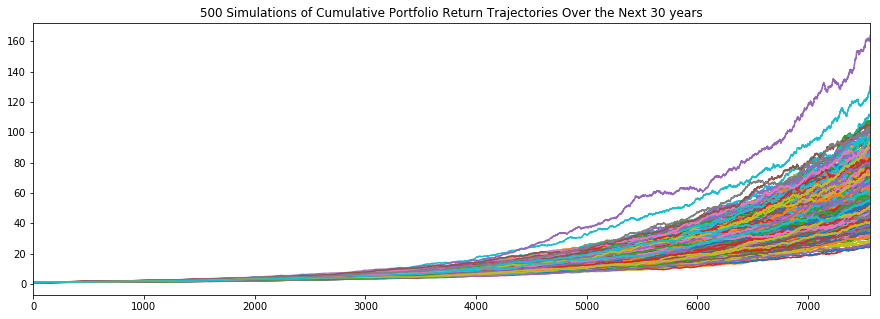

In [56]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 years"
portfolio_cumulative_returns.plot(legend=None, title = plot_title, figsize=(15,5) )

In [57]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_portfolio_prices = portfolio_cumulative_returns.iloc[-1, :]
ending_portfolio_prices.head()

0    59.169344
1    53.378139
2    57.292559
3    49.197032
4    56.380445
Name: 7560, dtype: float64

In [58]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_portfolio_prices.value_counts(bins=10) / len(ending_portfolio_prices)

(52.234, 66.184]      0.336
(38.284, 52.234]      0.262
(66.184, 80.133]      0.204
(80.133, 94.083]      0.090
(24.194, 38.284]      0.066
(94.083, 108.033]     0.036
(149.881, 163.831]    0.002
(121.982, 135.932]    0.002
(108.033, 121.982]    0.002
(135.932, 149.881]    0.000
Name: 7560, dtype: float64

In [59]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_portfolio_prices.quantile(q= [0.05, 0.95])
confidence_interval

0.05    37.135396
0.95    90.971153
Name: 7560, dtype: float64

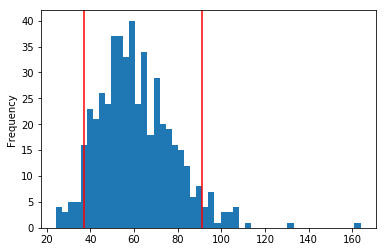

In [60]:
# Visualize the distribution of the ending returns
plt.figure();
ending_portfolio_prices.plot(kind='hist', bins=50)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [61]:
# Compute cumulative returns
expected_return_10th_percentile = round(ending_portfolio_prices.quantile(0.1), 2)
expected_return_50th_percentile = round(ending_portfolio_prices.quantile(0.5), 2)
expected_return_90th_percentile = round(ending_portfolio_prices.quantile(0.9), 2)
print(f"The expected cumulative returns at 30 years for the 10th percentile is {expected_return_10th_percentile},")
print(f"50th percentile is {expected_return_50th_percentile} and 90th percentile is {expected_return_90th_percentile}.")

The expected cumulative returns at 30 years for the 10th percentile is 40.2,
50th percentile is 58.91 and 90th percentile is 82.98.


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [62]:
# Set initial investment
initial_investment = 20000
# Compute expected portfolio return
expected_dollar_return_10th_percentile = round(initial_investment * (ending_portfolio_prices.quantile(0.1)), 2)
expected_dollar_return_50th_percentile = round(initial_investment * (ending_portfolio_prices.quantile(0.5)), 2)
expected_dollar_return_90th_percentile = round(initial_investment * (ending_portfolio_prices.quantile(0.9)), 2)
print(f"The expected cumulative returns at 30 years in dollars at the 10th percentile is ${expected_dollar_return_10th_percentile:,},")
print(f"50th percentile is ${expected_dollar_return_50th_percentile:,} and 90th percentile is ${expected_dollar_return_90th_percentile:,}.")

The expected cumulative returns at 30 years in dollars at the 10th percentile is $803,952.06,
50th percentile is $1,178,287.29 and 90th percentile is $1,659,614.77.


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [63]:
# Set Plaid's projected income
projected_yearly_income = 6085  # From the previous session, we found that the projected yearly income from the Plaid was $6085 (after tax)

# Calculate the 4% withdrawal for the ending return as retirement income
withdraw_rate = 0.04
retirement_income = round(expected_dollar_return_10th_percentile * withdraw_rate, 2)

# Determine if the retirement income meets or exceeds the current projected income
if retirement_income >= projected_yearly_income:
    print(f'The retirement income meets or exceeds the current projected annual income by ${retirement_income - projected_yearly_income:,}')
else:
    print(f'The retirement income does not meet or exceed the current projected annual income, falling short of ${projected_yearly_income - retirement_income:,}')

The retirement income meets or exceeds the current projected annual income by $26,073.08


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [64]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
initial_investment_increase = 20000 * 1.5
# Compute expected portfolio return
expected_dollar_return_10th_percentile_increase = round(initial_investment_increase * (ending_portfolio_prices.quantile(0.1)), 2)
retirement_income = round(expected_dollar_return_10th_percentile_increase * withdraw_rate, 2)
# Determine if the retirement income meets or exceeds the current projected income
if retirement_income >= projected_yearly_income:
    print(f'The retirement income meets or exceeds the current projected annual income by ${retirement_income - projected_yearly_income:,}')
else:
    print(f'The retirement income does not meet or exceed the current projected annual income, falling short of ${projected_yearly_income - retirement_income:,}')

The retirement income meets or exceeds the current projected annual income by $42,152.12


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

#### Since each quartile is interpolated by default, we need to find the nearest value to each quartile to find out the specific cumulative return.

In [65]:
# Find the nearest to each of 5th, 50%, 95% quartile.
nearest_5th = ending_portfolio_prices.quantile([0.05][0], interpolation='nearest')
nearest_50th = ending_portfolio_prices.quantile([0.5][0], interpolation='nearest')
nearest_95th = ending_portfolio_prices.quantile([0.95][0], interpolation='nearest')

In [66]:
# Define a function that returns each index of the above three quratiles
def index_finder(nearest_value):
    for i in range(len(ending_portfolio_prices)):
         if ending_portfolio_prices.get(i) == nearest_value:
            return i
# Test for nearest_5th
index_finder(nearest_95th)

383

### Using the index_finder function to get each portfolio cumulative returns, given initial investment of USD20,000 

In [67]:
# Compute projected returns
cumulative_return_5th_quartile = initial_investment * portfolio_cumulative_returns[index_finder(nearest_5th)]
cumulative_return_50th_quartile = initial_investment * portfolio_cumulative_returns[index_finder(nearest_50th)]
cumulative_return_95th_quartile = initial_investment * portfolio_cumulative_returns[index_finder(nearest_95th)]

# Display sample data
cumulative_return_95th_quartile.head()

0    20000.000000
1    19893.118047
2    19936.765850
3    20006.534554
4    20017.143977
Name: 383, dtype: float64

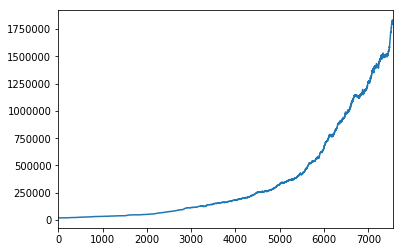

In [68]:
# Plot the cumulative returns over time
cumulative_return_95th_quartile.plot()

#### Lastly, plot projected performance over time by overlaying each quartile into a single plot

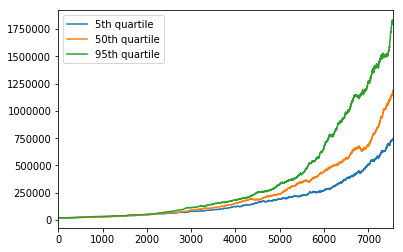

In [69]:
# Plot projected performance over time
ax = cumulative_return_5th_quartile.plot()
cumulative_return_50th_quartile.plot(ax=ax)
cumulative_return_95th_quartile.plot(ax=ax)

ax.legend(['5th quartile', 
           '50th quartile', 
           '95th quartile'])